In [40]:
import numpy as np, matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from typing import Callable
from numpy.typing import NDArray

In [41]:
# ----- INITIALISE -----
R_MAX = 1
R_MIN = 0.1
R_RES = 2500
EPS = 1e-12
BIN_PREC = 2 #TODO: round to a certain number bins instead of to a number of decimal places
NUM_BINS_SMAK = 400
U_MAX = R_MIN**(-0.5)

coords = np.linspace(-R_MAX, R_MAX, 2*R_RES)      # 1D coordinate vector
x_vals, y_vals = np.meshgrid(coords, coords)    # 2D grid
radii = np.hypot(x_vals, y_vals)                # distances from origin
thetas = np.arctan2(y_vals, x_vals)             # angles from origin
mask = (radii >= R_MIN) & (radii <= R_MAX)      # points within the disc

In [ ]:
# ----- FUNCTION DEFINITIONS -----

def get_intens(r: float, theta: float, a: float = 1.5) -> float:
    """
    Returns the brightness on the accretion disk at a given radius
    according to the inverse power law r^(-a)
    """
    return r**(-a)

def get_vel(r: float, theta: float) -> float:
    """
    Returns the velocity of a particle at a given polar coordinate.
    """
    return np.cos(theta) / np.sqrt(r)

def get_2d_profile(func: Callable[[float, float, float], float], a: float = None) -> np.ndarray[np.float64]:
    """
    Compute a 2D profile of values from `func(r, theta, a)` on the masked domain. `a`
    argument is optional.
    """
    values = np.full_like(radii, np.nan, dtype=float) # make grid of NaNs
    masked_radii = np.maximum(radii[mask], EPS)
    masked_thetas = thetas[mask]

    # reassign values within the mask to the func values
    if a is None:
        values[mask] = func(masked_radii, masked_thetas) 
    else:
        values[mask] = func(masked_radii, masked_thetas, a)

    return values

def plot_2d_profile(
    values: np.ndarray[np.float64], *,
    colourmap: str = "viridis",
    title: str = "Profile",
    x_label: str = "x", y_label: str = "y",
    colour_bar_name: str = "Value",
    figure_size: tuple[int, int] = (6, 6),
    vmin: float = None, vmax: float = None,
    colour_contrast_style: str = "custom"
        # "symmetric" to set symmetric color limits around 0 (for signed fields)
        # "nonneg" to force vmin=0 and vmax=max (for non-negative fields)
) -> None:
    """
    Plots a 2D numpy array of values on a grid with a colour bar.
    """
    # Auto colour scaling helpers
    if colour_contrast_style == "symmetric":    # colour bar ranges from - max val to + max val 
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto
        vmax_plot =  vmax_auto
    elif colour_contrast_style == "nonneg":     # colour bar ranges from 0 to max val
        vmin_plot = 0.0
        vmax_plot = np.nanmax(values)
    elif (
        colour_contrast_style == "custom" and   # colour bar ranges from vmin to vmax
        vmin is not None and vmax is not None
    ):
        vmin_plot = vmin
        vmax_plot = vmax
    else:
        raise Exception("invalid colour contrast arguments")

    plt.figure(figsize = figure_size)

    img = plt.imshow(
        values,
        origin="lower",
        cmap=colourmap,
        aspect="equal",
        vmin=vmin_plot, vmax=vmax_plot
    )

    cbar = plt.colorbar(img)
    cbar.set_label(colour_bar_name, rotation=270, labelpad=15)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

    return values

def get_vel_bins_and_intens(
    intens_func: Callable[[float, float, float], float] = get_intens,
    a: float = 1.5,
    noramlise: bool = True,
    plot_disk_vels: bool = False,
    plot_disk_intens: bool = True
) -> tuple[np.ndarray[np.float64], np.ndarray[np.float64]]:
    """
    Returns a tuple of unique rounded velocity bin starts, and the associated
    brightness/intensity with each bin (normalised).
    """
    velocities = get_2d_profile(get_vel)
    intensities = get_2d_profile(intens_func, a) #TODO: figure out how to pass `a` in 

    if plot_disk_vels:
        plot_2d_profile(
            values = velocities,
            colourmap = "seismic",
            title = "Doppler Shift",
            colour_bar_name = "Velocity",
            colour_contrast_style = "symmetric"
        )
    if plot_disk_intens:
        plot_2d_profile(
            intensities,
            colourmap = "inferno",
            title = f"Radial Brightness Profile (a={a})",
            colour_bar_name = "Brightness",
            colour_contrast_style = "nonneg"
        )

    rounded_vels = np.round(velocities, BIN_PREC) # discretise by rounding


    # Keep valid points
    finite_mask = np.isfinite(rounded_vels) & np.isfinite(intensities)
    finite_rounded_vels = rounded_vels[finite_mask]
    finite_weights = intensities[finite_mask]

    # Group by unique rounded frequency and sum brightness
    uniq_rounded_vels, inverse_indices = np.unique(finite_rounded_vels, return_inverse=True)
    sum_brightness = np.bincount(inverse_indices, weights=finite_weights)

    if noramlise:
        # Normalise max brightness to to 1
        sum_brightness /= np.max(sum_brightness)
    
    return (uniq_rounded_vels, sum_brightness)

def plot_spectrum_list(
    a_vals: np.ndarray[np.float64] = np.arange(0, 2.51, 0.5),
    plot_smak: bool = False,
    sigma: float = None, *,
    xlim: tuple[float, float] = (-5, 5),
    xlabel="Relative Speed",
    ylabel="Brightness",
    title="Light Spectrum",
    figure_size: tuple[float, float] = (8, 5),
    grid_alpha: float = 0.3
) -> None:
    """
    Plots the model intensity over a range of u values (speeds/wavelengths) for a disk with
    brightness decsribed by :func:`get_intens` over a range of `a_vals`. Optionally plots
    Smak analytical solitions on top if `plot_smak` is `True`.
    """
    if a_vals is None or len(a_vals) == 0:
        return

    if sigma is not None and sigma <= 0:
        raise Exception("Invalid sigma argument")

    plt.clf()
    plt.figure(figsize=figure_size)

    for a in a_vals:
        uniq_rounded_vels, sum_brightness = get_vel_bins_and_intens(
            a = a, plot_disk_vels = False, plot_disk_intens = False
        )

        if sigma is not None:
            sum_brightness = gaussian_filter1d(sum_brightness, sigma=sigma)

        model_label = f"a = {a}"

        if plot_smak:
            smak_u_vals = np.linspace(-U_MAX, U_MAX, NUM_BINS_SMAK)
            smak_brightness = smak_F(smak_u_vals, a)
            if sigma is not None:
                smak_brightness = gaussian_filter1d(smak_brightness, sigma=sigma)
            
            model_label = f"Model (a={a})"
            smak_label = f"Smak (a={a})"

            plt.plot(
                smak_u_vals, smak_brightness,
                linestyle = "--", label=smak_label
            )

        plt.plot(
            uniq_rounded_vels, sum_brightness,
            linestyle = '-', label = model_label
        )

    plt.xlabel(f"{xlabel} (rounded to {BIN_PREC} dp)")
    plt.ylabel(ylabel)
    smoothtag = f" (Gaussian smoothed, sigma={sigma:g})" if (sigma is not None and sigma > 0) else ""
    plt.title(title + smoothtag)
    plt.grid(True, alpha=grid_alpha)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.legend()
    plt.tight_layout()
    plt.show()



# ----- SMAK FUNCTIONS -----

def smak_F(u_vals: np.ndarray[np.float64], a: float) -> np.ndarray[np.float64]:
    """
    Returns a numpy array of intensity values F(u) associated with the array
    of `u_vals` given, according to Smak\'s analytical solution.
    """
    intensities = np.full_like(u_vals, np.nan, float)   # make array of NaNs

    exp = 2*a - 5
    root_r_min = np.sqrt(R_MIN)

    for j, u in enumerate(u_vals):
        # guard the singular prefactor at u=0 if exponent < 0
        if abs(u) < EPS and exp < 0:
            intensities[j] = np.nan
            continue

        x_z = np.clip(u, -1.0, 1.0)
        x_1 = np.clip(u * root_r_min, -1.0, 1.0)

        upper = smak_I(a, x_z)
        lower = smak_I(a, x_1)
        diff  = upper - lower

        intensities[j] = (u**exp) * diff

    # normalise robustly (optional)
    finite = np.isfinite(intensities)
    norm_intens = intensities
    if finite.any(): # check if any intensities are finite
        amp = np.nanmax(np.abs(intensities))
        if (np.isfinite(amp) and amp > 0):
            norm_intens = intensities / amp

    return norm_intens

def smak_I(a: float, x: float) -> float:
    """
    Helper function for :func:`smak_F`.
    """
    result = np.nan
    if abs(x) <= 1.0:
        s = np.sqrt(1.0 - x**2)
        if a == 0.0:
            result = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            result = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            result = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            result = -s
        elif a == 2.0:
            result = np.arcsin(x)
        elif a == 2.5:
            result = np.log(abs((1.0 - s) / x)) if abs(x) > EPS else np.nan
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")
    return result

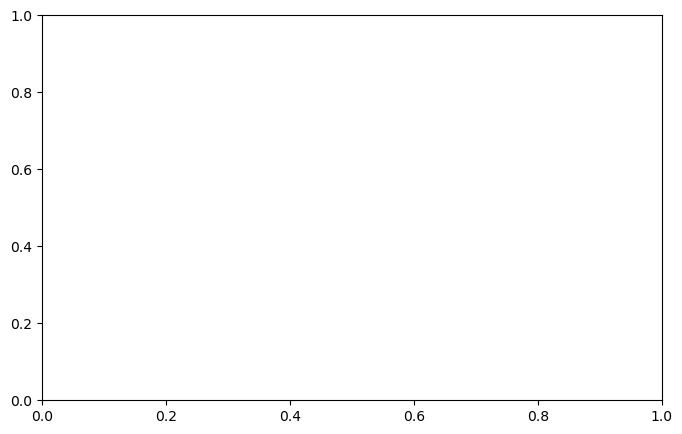

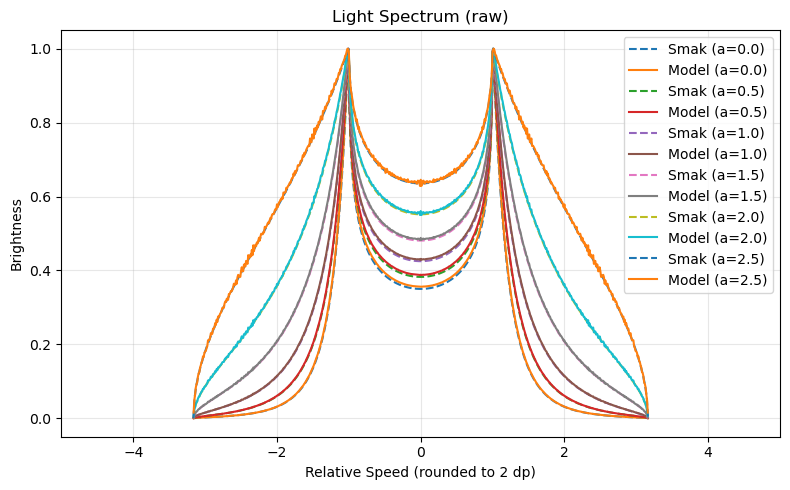

In [48]:
# ----- TESTING -----

plot_spectrum_list(plot_smak=True, title="Light Spectrum (raw)")